The basics of this notebook come from [here]("https://towardsdatascience.com/understanding-graph-convolutional-networks-for-node-classification-a2bfdb7aba7b").

The main objective is to explore the integration of word embeddings in graph representations.

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
import random

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

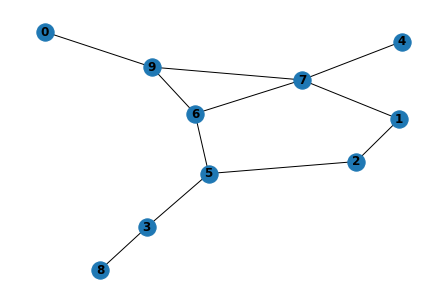

In [71]:
#graph initialization
G = nx.Graph(name='G')

num_nodes = 10
num_edges = 12

for i in range(num_nodes):
    G.add_node(i, name=i)
    
    G.nodes[i]["vector"] = list(np.random.randint(2, size=10))


subjects = np.random.choice(range(0, num_nodes), size=num_edges, replace=True)
objects = np.random.choice(range(0, num_nodes), size=num_edges, replace=True)


for i in range(num_edges):
    G.add_edge(subjects[i], objects[i])

    
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [74]:
#get the adjacency matrix A

A = np.array(nx.attr_matrix(G, node_attr='name')[0])

#get the node feature matrix X

X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X,axis=1)

print('Shape of A: ', A.shape)
print('\nShape of X: ', X.shape)
print('\nAdjacency Matrix (A):\n', A)
print('\nNode Features Matrix (X):\n', X)

Shape of A:  (10, 10)

Shape of X:  (10, 1)

Adjacency Matrix (A):
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]]

Node Features Matrix (X):
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]


/tmp/ipykernel_21089/2374077452.py:3: FutureWarning: attr_matrix will return an numpy.ndarray instead of a numpy.matrix in NetworkX 3.0.
  A = np.array(nx.attr_matrix(G, node_attr='name')[0])
/tmp/ipykernel_21089/2374077452.py:7: FutureWarning: attr_matrix will return an numpy.ndarray instead of a numpy.matrix in NetworkX 3.0.
  X = np.array(nx.attr_matrix(G, node_attr='name')[1])


In [75]:
# V will be a matrix of the vectors attributes
V = []

for node in G.nodes:
    vector = G.nodes[node]['vector']
    V.append(vector)

V = np.array(V)
print('Vector Matrix (V):\n', V)

Vector Matrix (V):
 [[1 0 0 1 0 1 0 1 1 0]
 [0 0 0 1 0 1 0 1 1 0]
 [1 1 0 0 1 0 1 1 0 1]
 [0 1 1 0 0 0 1 0 1 0]
 [0 1 1 1 0 1 0 1 1 1]
 [1 1 0 0 0 0 0 1 0 1]
 [0 0 1 0 1 1 1 0 1 0]
 [1 1 0 1 1 1 1 1 1 1]
 [1 0 0 1 0 1 1 1 0 0]
 [0 1 0 0 0 1 0 1 1 0]]


In [76]:
#Dot product Adjacency Matrix (A) and Node Features (X)
#each row in X corresponds to the sum of the features (in this case 0,1,..,n)
#connected to a specific node
#for instance, X[0][0] corresponds to the sum of features for eache node connected to the node 0
AX = np.dot(A,X)
print("Dot product of A and X (AX):\n", AX)

# this is more interesting since it has several features: both information from neighbors AND vectors
AV = np.dot(A,V)
print("Dot product of A and V (AV):\n", AV)


# the only issue we have is the lack of information from the node itself
# solution: add self loops 

Dot product of A and X (AX):
 [[ 9.]
 [ 9.]
 [ 6.]
 [13.]
 [ 7.]
 [11.]
 [21.]
 [20.]
 [ 3.]
 [13.]]
Dot product of A and V (AV):
 [[0. 1. 0. 0. 0. 1. 0. 1. 1. 0.]
 [2. 2. 0. 1. 2. 1. 2. 2. 1. 2.]
 [1. 1. 0. 1. 0. 1. 0. 2. 1. 1.]
 [2. 1. 0. 1. 0. 1. 1. 2. 0. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 2. 2. 0. 2. 1. 3. 1. 2. 1.]
 [2. 3. 0. 1. 1. 2. 1. 3. 2. 2.]
 [0. 2. 2. 2. 1. 4. 1. 3. 4. 1.]
 [0. 1. 1. 0. 0. 0. 1. 0. 1. 0.]
 [2. 1. 1. 2. 2. 3. 2. 2. 3. 1.]]


In [77]:
#Add Self Loops
G_self_loops = G.copy()

self_loops = []
for i in range(G.number_of_nodes()):
    self_loops.append((i,i))

G_self_loops.add_edges_from(self_loops)

#Check the edges of G_self_loops after adding the self loops
print('Edges of G with self-loops:\n', G_self_loops.edges)

#Get the Adjacency Matrix (A) and Node Features Matrix (X) of added self-lopps graph
A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0])
print('Adjacency Matrix of added self-loops G (A_hat):\n', A_hat)

#Calculate the dot product of A_hat and X (AX)
AX = np.dot(A_hat, X)
print('AX:\n', AX)

#Calculate the dot product of A_hat and V (AV)
AV = np.dot(A_hat, V)
print('AV:\n', AV)

Edges of G with self-loops:
 [(0, 9), (0, 0), (1, 2), (1, 7), (1, 1), (2, 5), (2, 2), (3, 8), (3, 5), (3, 3), (4, 7), (4, 4), (5, 6), (5, 5), (6, 9), (6, 7), (6, 6), (7, 9), (7, 7), (8, 8), (9, 9)]
Adjacency Matrix of added self-loops G (A_hat):
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]]
AX:
 [[ 9.]
 [10.]
 [ 8.]
 [16.]
 [11.]
 [16.]
 [27.]
 [27.]
 [11.]
 [22.]]
AV:
 [[1. 1. 0. 1. 0. 2. 0. 2. 2. 0.]
 [2. 2. 0. 2. 2. 2. 2. 3. 2. 2.]
 [2. 2. 0. 1. 1. 1. 1. 3. 1. 2.]
 [2. 2. 1. 1. 0. 1. 2. 2. 1. 1.]
 [1. 2. 1. 2. 1. 2. 1. 2. 2. 2.]
 [2. 3. 2. 0. 2. 1. 3. 2. 2. 2.]
 [2. 3. 1. 1. 2. 3. 2. 3. 3. 2.]
 [1. 3. 2. 3. 2. 5. 2. 4. 5. 2.]
 [1. 1. 1. 1. 0. 1. 2. 1. 1. 0.]
 [2. 2. 1. 2. 2. 4. 2. 3. 4. 1.]]


/tmp/ipykernel_21089/2200791179.py:14: FutureWarning: attr_matrix will return an numpy.ndarray instead of a numpy.matrix in NetworkX 3.0.
  A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0])


In [78]:
# another issue is that this model is currently biased towards nodes with many neighbors
# in order to solve this, we should normalize over nodes' degrees

#Get the Degree Matrix of the added self-loops graph
Deg_Mat = G_self_loops.degree()
print('Degree Matrix of added self-loops G (D): ', Deg_Mat)

#Convert the Degree Matrix to a N x N matrix where N is the number of nodes
D = np.diag([deg for (n,deg) in list(Deg_Mat)])
print('Degree Matrix of added self-loops G as numpy array (D):\n', D)

#Find the inverse of Degree Matrix (D)
D_inv = np.linalg.inv(D)
print('Inverse of D:\n', D_inv)

#Dot product of D and AX for normalization
DAX = np.dot(D_inv,AX)
print('DAX:\n', DAX)


#Dot product of D and AV for normalization
DAV = np.dot(D_inv,AV)
print('DAV:\n', DAV)

#Symmetrically-normalization
D_half_norm = fractional_matrix_power(D, -0.5)
DADX = D_half_norm.dot(A_hat).dot(D_half_norm).dot(X)
print('DADX:\n', DADX)

#Dot product of D and AV for symmetrically-normalization
DAV = np.dot(D_inv,AV)
print('DAV:\n', DAV)

Degree Matrix of added self-loops G (D):  [(0, 3), (1, 4), (2, 4), (3, 4), (4, 3), (5, 5), (6, 5), (7, 6), (8, 3), (9, 5)]
Degree Matrix of added self-loops G as numpy array (D):
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 5]]
Inverse of D:
 [[0.33333333 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.25       0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.25       0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.25       0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.33333333 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.  

In [79]:
#time to add weights and the activation function (ReLu in this case)

#Initialize the weights
np.random.seed(77777)
n_h = 4 #number of neurons in the hidden layer
n_y = 3 #number of neurons in the output layer
W0 = np.random.randn(X.shape[1],n_h) * 0.01
W1 = np.random.randn(n_h,n_y) * 0.01
W_matrix = []

#Implement ReLu as activation function
def relu(x):
    return np.maximum(0,x)

#Build GCN layer
#In this function, we implement numpy to simplify
def gcn(A,H,W):
    I = np.identity(A.shape[0]) #create Identity Matrix of A
    A_hat = A + I #add self-loop to A
    D = np.diag(np.sum(A_hat, axis=0)) #create Degree Matrix of A
    D_half_norm = fractional_matrix_power(D, -0.5) #calculate D to the power of -0.5
    eq = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
    return relu(eq)


#Do forward propagation
H1 = gcn(A,X,W0)
H2 = gcn(A,H1,W1)

max_iter = 10
weights = W0
features = X
for i in range(max_iter):
    print(f'...working on iteration {i}...', end='\r')
    h=gcn(A,features,weights)
    
    
print('Features Representation from GCN output:\n', H2)

Features Representation from GCN output:
 [[0.00049168 0.00016502 0.00035746]
 [0.00047762 0.0001603  0.00034724]
 [0.0004195  0.00014079 0.00030498]
 [0.00074337 0.00024949 0.00054044]
 [0.00057975 0.00019458 0.00042149]
 [0.00071454 0.00023981 0.00051948]
 [0.00076823 0.00025783 0.00055852]
 [0.00084576 0.00028386 0.00061488]
 [0.00070038 0.00023506 0.00050919]
 [0.00077909 0.00026148 0.00056641]]


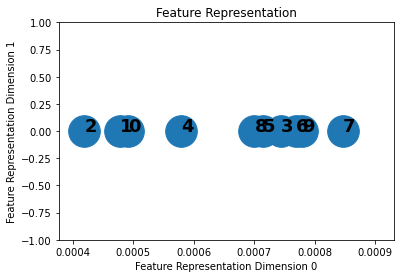

In [80]:
def plot_features(H2):
    #Plot the features representation
    x = H2[:,0]
    y = H2[:,1]

    size = 1000

    plt.scatter(x,y,size)
    plt.xlim([np.min(x)*0.9, np.max(x)*1.1])
    plt.ylim([-1, 1])
    plt.xlabel('Feature Representation Dimension 0')
    plt.ylabel('Feature Representation Dimension 1')
    plt.title('Feature Representation')

    for i,row in enumerate(H2):
        str = "{}".format(i)
        plt.annotate(str, (row[0],row[1]),fontsize=18, fontweight='bold')

    plt.show()


plot_features(H2)